The idea of the chapter is to look at inside models which seems like black boxes. <br>
In this chapter, we will start by looking a the Linear Regression model. We will discuss two very different ways to train it:
- Using a direct "closed-form" equation that directly computes the model parameters that best fit the model to the training set.
- Using an iterative optimization approach, called Gradient Descent (GD), that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of Gradient Descent that we will use again and again when we study neural networks: __Batch GD, Mini-batch GD and Stochastic GD__ 

After we will look at Polynomial Regression, Logistic Regression and softmax regression

## Linear Regression

A linear Model makes a prediction by simply computing a weigthed sum of the input features, plus a constant called the _bias term_ (also called the _intercept term_) <br>
$\hat{y} = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{n}x_{n}$
<br>$\hat{y}$ the predicted value 
<br>$x_{i}$ the ith feature value 
<br>$\theta_{j}$ the jth model parameter (including the bias parameter $\theta_{0}$
<br> Or more concisely this equation can be write like this <br>
$\hat{y} = h_{\theta}(x) = \theta x$

So now how do we train it? Recall that training a model means setting its parameters so that the model vest fits the training set. For this purpose, you need to find the value of $\theta$ that minimizes the RMSE (performance measure of a regression model). In practice, it's simpler to min MSE than the RMSE and it leads to the same result.

The MSE of a linear Regression hypothesis $h_{\theta}$ on a training set X is calculated using <br>
$ MSE(X,h_{\theta}) = \frac{1}{m} \sum \limits _{i=1}^{m} (\theta^{T}x^{(i)} - y^{(i)})^{2} $

### Normal Equation

To find the value of $\theta$ that minimizes the cost function, there is a _closed-form solution_ <br>
$\hat{\theta} = (X^{T}X)^{-1} X^{T} y$ <br>
$\hat{\theta}$ is the value of $\theta$ that min the cost function

Let's generate some linear-looking data to test this equation

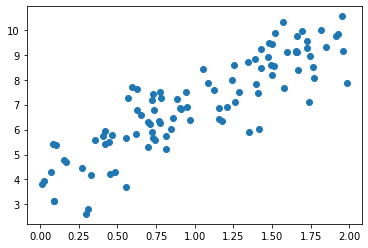

In [6]:
import numpy as np
import matplotlib.pyplot as plt
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)
plt.scatter(X,y)
plt.show()

In [8]:
# Let's compute theta using the normal equation
X_b = np.c_[np.ones((100, 1)), X] # add x0=1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.02275584],
       [2.94476597]])

In [10]:
# Let's make predictions using theta_best
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.02275584],
       [9.91228778]])

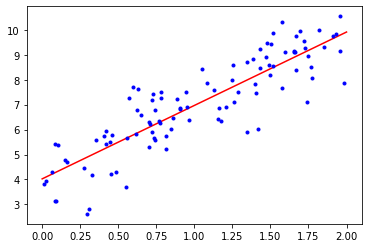

In [13]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")

Note that linear regression using Scikit-Learn is quite simple. The LinearRegressionClass is based on the scipy.linalg.lstsq() function (the name stands for "least squares") which you could call directly

In [14]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.02275584],
       [2.94476597]])

This function computes $\hat{\theta} = X^{+}y$ where $X^{+}$ is the _pseudoinverse_ of X (Moore-Penrose inverse). You can use np.linalg.pinv() to compute the pseudoinverse directly

In [15]:
np.linalg.pinv(X_b).dot(y)

array([[4.02275584],
       [2.94476597]])

The pseudoinverse is computed using a standard matrix factorization technique called SVD that can decompose X into matrix multiplication of 3 matrices $U \Sigma^{+}  V^{T}$. <br> the pseudoinverse is computed as $X^{+} = V\Sigma^{+} U^{T}$. To compute $\Sigma^{+}$ the algo takes $\Sigma$ and sets to zero all values smaller than a tiny threshold value, then it replaces all the non-zero values with their inverse and finally it transposes the resulting matrix. <br> This approach is more efficient than computing the Normal Equation plus it handles edge cases nicely: indeed, the Normal Equation may not work if the matrix $X^{T}X$ is not invertible (i.e., singular), such as if m < n or if some features are redundant, but the pseudoinverse is always defined.

Both normal equation and SVD approach get very slow whent the number of features grows large. On the positive side, both are linear with regards to the number of instances in the training set (they are O(m)), so they handle large training sets efficiently, provided they can fit in memory.

## Gradient Descent

GD is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of GD is to tweak parameters iteratively in order to minimize a cost function.
<br>Concretely, you start by filling $\theta$ with random values and then you improve it gradually, taking one baby step at a time, each steap attempting to decrease the cost function (e.g. the MSE) until the algo _converges_ to a minimum

An important parameter in GD is the step size, determined by the learning rate hyperparameter. If the learning rate is too small, then the algo will have to go through many iterations to converge which will take a long time. <br> On the other hand, if the learning rate is too high, this might make the algo diverge, failing to find a good solution.

Fortunately, MSE happens to be a convex function and it's also a continuous function with a slope that never changes abruptly. So GD is guaranteed to approach arbitrarily close to the global minimum.

When using GD, you should ensure that all features have a similar scale (using StandardScaler class of scikit-learn) or else it will take much longer to converge.

### Batch Gradient Descent 

To implement GD, you need to compute the gradient of cost functon with regards to each model parameter $\theta_{j}$

Equation Partial derivatives of the cost function<br>
$\frac{\partial}{\partial \theta_{j}}MSE(\theta) = \frac{2}{m} \sum \limits_{i=1}^{m}(\theta^{T}x^{(i)} - y^{(i)})x_{j}^{(i)}$

Instead of computing these partial derivatives individually, you can use the following equation to compute them all in one go.<br>
Equation Gradient vector of the cost function<br>
$\nabla_{\theta} MSE(\theta) = \frac{2}{m}X^{T}(X \theta - y)$

Notice that this formula involves calculations over the full training set X, at each Gradient Descent step. This is why the algorithm is called Batch Gradient Descent. It's terribly slow on very large training sets. However GD scales well with the number of features; training a Linear Regression model when there are hundreds of thousands features is much faster using GD than using SVD decomposition or Normal Equation.

In [16]:
#let's implement it
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

theta

array([[4.02275584],
       [2.94476597]])

To find a good learning rate, you can use grid search. <br>
To limit the number of iterations so that grid search can eliminate models that take too long to converge, you can set a very large number of iterations but interrupt the algo when the gradient vector becomes tiny (smaller than a tiny number called the tolerance) because this happens when GD has reached the min

### Stochastic Gradient Descent 

At the opposite extreme of batch GD, SGD picks a random instance in the training set at every step and computes the gradients based only on that single instance. On the other hand, due to its stochastic nature, this algorithm is much less regular than Batch GD.: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down. <br> So once the algorithm stops, the final parameter values are good, but not optimal

Therefore randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. One solution to this dilemma is to gradually reduce the learning rate. The steps start out larg, then get smaller and smaller, allowing the algorithm to settle at the global minimum. The function that determines the learning rate at each iteration is called the __learning schedule__

In [17]:
# implementation of SGD using a simple learning schedule
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparams

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m - yi)
        theta = theta - eta * gradients
    
theta

array([[4.04839187],
       [2.96715356]])

Note that since instances are picked randomly, some instances may be picked several times per epoch while others may not be picked at all. If you don't want this, another approach is to shuffle the training set. However, this generally converges more slowly.

When using Stochastic Gradient Descent, the training instances must be independent and identically distributed to ensure that the parameters get pulled towards the global optimum, on average (A simple way to ensure this is to shuffle the instances during training).

In [19]:
# Let's implement SGD using Scikit-Learn
from sklearn.linear_model import SGDRegressor

# maximum 1000 epochs (max_iter=1000)
# until the loss drops by less than 1e-3 during one epoch (tol=1e-3), 
# starting with a learning rate of 0.1 (eta0=0.1), using the default learning schedule (different from the preceding one)
# and it does not use any regularization (penalty = None)
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([3.95152595]), array([2.918769]))

### Mini-batch Gradient Descent

at each step, instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called mini-batches.<br>
The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs

### Comparison

![title](img/GD_paths_in_space.png)

![title](img/comparison_algos_linear_regression.png)

## Polynomial Regression

What if your data is actually more complex than a simple straight line? Surprisingly, you can actually use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called _Polynomial Regression_

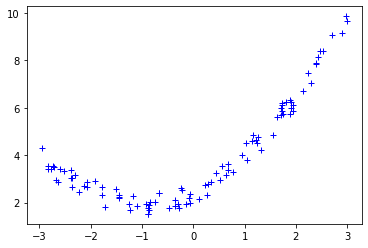

In [22]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.rand(m,1)

plt.plot(X, y, "b+")

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
# X_poly contains the original feature of X plus the square of this feature

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.45513148]), array([[1.00562874, 0.50995155]]))

Polynomialfeatures (degree=d) transforms an array containing n features into an array containing $\frac{(n+d)!}{d!n!}$ features where $n!$ is the factorial of n (=1x2x...xn). Be aware

### Learning curves

Another way to know if a model os too simple or too complex is to look at the learning curves (first is cross-validation).<br>
These are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration)

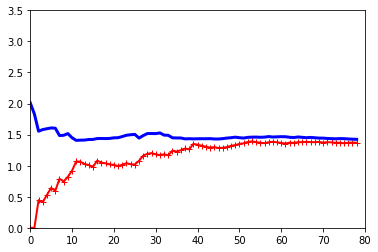

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.axis([0, 80, 0, 3.5])
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

These learning curves are typical of an underfitting model. Both curves have reached a plateau, they are close and fairly high<br>
Now let's look at the learning curves of 10th degree polynomial model on the same data

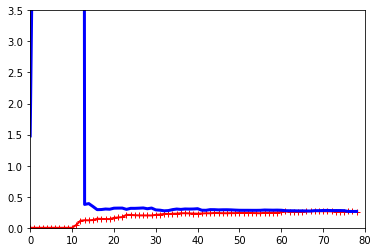

In [40]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

### Bias/Variance tradeoff

An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors

__Bias__ <br>
This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data<br>
__Variance__ <br>
This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.
<br>
__Irreducible error__<br>
This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).<br>

Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a tradeoff.

## Regularized Linear Models

A good way to reduce overfitting is to regularize the model.<br>
For a linear model, regularization is typically achieved by constraining the weights of the model.

### Ridge Regression

Ridge Regression (also called Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal to $\alpha \sum \limits_{i=1}^{n} \theta^{2}_{i}$ is added to the cost function.
This forces the learning algorithm to not only fit the data but also keep the model
weights as small as possible. Note that the regularization term should only be added to the cost function during training

The hyperparameter $\alpha$ controls how much you want to regularize the model
<br>__Ridge Regression cost function__<br>
$ J(\theta) = MSE(\theta) + \alpha \sum \limits_{i=1}^{n} \theta^{2}_{i}$
<br> Note that the bias term is not regularized

As with Linear Regression, we can perform Ridge Regression either by computing a closed-form equation or by performing Gradient Descent. The pros and cons are the same.<br>
Ridge Regression closed-form solution<br>
$\hat{\theta} = (X^{T}X + \alpha A)^{-1} X^{T} y$
<br>where A is the (n + 1) × (n + 1) identity matrix except with a 0 in the top-left cell, corresponding to the bias term

In [49]:
# Performing Ridge Regression with Scikit-Learn
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1]])

array([4.89682124])

In [50]:
# Using Stochastic Gradient Descent
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1]])

array([4.85709692])

Remark: Specifying indicates that you wand SGD to add a regularization term to the cost function equal to half the square of the $l2$ norm of the weight vector.

### Lasso Regression 
Just like Ridge regression, it adds a regularization term to the cost function, but it uses the $l1$ norm of the weight vector instead of half the square of the $l2$ norm
<br> Lasso regression cost function 
$ J(\theta) = MSE(\theta) + \alpha \sum \limits_{i=1}^{n} |{\theta_{i}}|$
<br> An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the least important feature. 
<br>
The Lasso cost function is not differentiable at $\theta_{i}= 0 (for i = 1, 2, ⋯, n)$, but Gradient Descent still works fine if you use a subgradient vector g instead when any $\theta_{i}= 0$.
<br>
$g(\theta, J) = \nabla_{\theta} MSE(\theta) + \alpha \begin{bmatrix} sign(\theta_{1}) \\ ... \\ sign(\theta_{n}) \end{bmatrix}$ where $sign(\theta_{i}) = \begin{matrix} -1 if \theta_{i} < 0 \\ 0 if \theta_{i} = 0 \\ +1 if \theta_{i} > 0 \end{matrix}$

In [52]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.31524861])

### Elastic Net 
Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio r. When r = 0, Elastic Net is equivalent to Ridge Regression, and when r = 1, it is equivalent to Lasso Regression<br>
Elastic Net cost function<br>
$J(\theta) = MSE(\theta) + r \alpha \sum \limits_{i=1}^{n} |{\theta_{i}}| + \frac{1-r}{2}\sum \limits_{i=1}^{n} \theta_{i}^{2} $

So when should you use plain Linear Regression (i.e., without any regularization), Ridge, Lasso, or Elastic Net? It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain Linear Regression. Ridge is a good default, but if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net since they tend to reduce the useless features’ weights down to zero as we have discussed. In general, Elastic Net is preferred over Lasso since Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

In [53]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.31778864])

### Early Stopping
A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called _early stopping_
<br>With Stochastic and Mini-batch Gradient Descent, the curves are not so smooth, and it may be hard to know whether you have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time

In [56]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)


/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             tol=-inf, warm_start=True)

Note that with warm_start=True, when the fit() method is called, it just continues training where it left off instead of restarting from scratch.

## Logistic Regression

### Estimating Probabilities
So how does it work? Just like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the logistic of this result
<br> 
Logistic Regression model estimated probability
<br> 
$\hat{p}= h_{\theta}(x) = \sigma(X^{T} \theta)$
<br> 
the logistic is a sigmoid function that outputs a number btw 0 and 1
<br> 
$\sigma(t) = \frac{1}{1 + exp(-t)}$

### Training and cost Function
The objective of training is to set the param‐ eter vector θ so that the model estimates high probabilities for positive instances (y = 1) and low probabilites for negative instances (y = 0)
<br>
$c(\theta) = \begin{matrix} -log(\hat{p})_\text{if y = 1} \\ -log(1 - \hat{p})_ \text{if y = 0}\end{matrix}$
<br>
This cost function makes sense because – log(t) grows very large when t approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be very large if the model estimates a probability close to 1 for a negative instance.
<br>
The cost function over the whole training set is simply the average cost over all training instances
<br>
Logistic regression cost function (log loss)
$J(\theta) = -\frac{1}{m} \sum \limits_{i=1}^{m} [y^{(i)}log(\hat{p}^{(i)} + (1 - y^{(i)})log(1 - \hat{p}^{(i)}] $

<br>
The bad news is that there is no known closed-form equation to compute the value of θ that minimizes this cost function. But the good news is that this cost function is convex, so Gradient Descent (or any other optimization algorithm) is guaranteed to find the global minimum. The partial derivatives of the cost function with regards to the jth model parameter θj is
<br>
$\frac{\partial}{\partial \theta_{j}}J(\theta) = \frac{1}{m} \sum \limits_{i=1}^{m}(\sigma(\theta^{T}x^{(i)}) - y^{(i)})x_{j}^{(i)}$
<br>
for each instance it computes the prediction error and multiplies it by the jth feature value, and then it computes the average over all training instances. Once you have the gradient vector containing all the partial derivatives you can use it in the Batch Gradient Descent algorithm

### Decision Boundaries
Let's use the dataset to illustrate Logistic Regression. This is a dataset that contains the sepal and petal length and width of 150 iris flowers of 3 different species: Iris-Setosa, Iris-Versicolor and Iris-Virginica
Let's try to build a classifier to detect the Iris-Virginica type based only on the petal width feature.

In [60]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [61]:
X = iris["data"][:, 3:] #petal width
y = (iris["target"] == 2).astype(np.int) # 1 if Virginica and 0 else

In [62]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

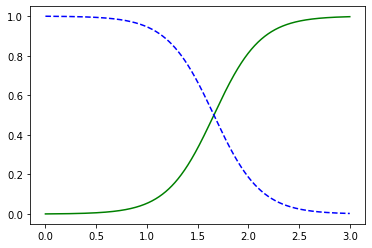

In [65]:
# model's estimated proba for flowers with petals width varying from 0 to 3 cm
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")

Therefore, there is a decision boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal width is higher than 1.6 cm, the classifier will predict that the flower is an Iris-Virginica, or else it will predict that it is not (even if it is not very confident)
<br>
Just like the other linear models, Logistic Regression models can be regularized using l1 or l2 penalties. Scitkit-Learn actually adds an l2 penalty by default

### Softmax Regression
The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers. This is called _Softmax Regression or Multinomial Logistic regression_ <br>
The idea is quite simple: when given an instance x, the Softmax Regression model first computes a score $s_{k}(x)$ for each class k, then estimates the probability of each class by applying the softmax function (also called the normalized exponential) to the scores. <br>
Softmax score for class k $s_{k}(x) = x^{T}\theta^{(k)}$ <br>
Once you have computed the score of every class for the instance x, you can estimate the probability pk that the instance belongs to class k by running the scores through the following softmax function. <br>
$\hat{p_{k}} = \frac{ exp(s_{k}(x)) }{ \sum \limits_{j = 1}^{K} exp(s_{j}(x))} $ 
<br>
with K the number of classes
<br>
Just like the Logistic Regression classifier, the Softmax Regression classifier predicts the class with the highest estimated probability.
<br>
Now that you know how the model estimates probabilities and makes predictions, let’s take a look at training. The objective is to have a model that estimates a high probability for the target class. 
Minimizing the cost function, called the cross entropy, and it penalizes the model when it estimates a low probability for a target class
<br>
$J(\Theta) = -\frac{1}{m} \sum \limits_{i=1}^{m} \sum \limits_{k=1}^{K} y_{k}^{(i)}log(\hat{p}_{k}^{(i)})$
<br> <br>
The gradient vector of this cost function with regards to $\theta^{(k)}$ is 
<br>
$\nabla_{\theta^{(k)}}J(\Theta) = \frac{1}{m} \sum \limits_{i=1}^{m} (\hat{p}_{k}^{(i)} - y_{k}^{(i)})x^{(i)}$

Let's use Softmax Regression to classify the iris flowers into all three classes. Scikit-Learn’s LogisticRegression uses one-versus-all by default when you train it on more than two classes, but you can set the multi_class hyperparameter to "multinomial" to switch it to Softmax Regression instead. You must also specify a solver that supports Softmax Regression, such as the "lbfgs" solver

In [66]:
X = iris["data"][:, (2, 3)] # petal length and petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

softmax_reg.predict([[5, 2]])


array([2])

In [67]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])